### Aggregate data into conditions/groups

The purpose of this notebook is to read in the parsed files (for each subject, each video/condition) and combine them so that we have a file in which all subjects that viewed a particular video (and/or in a particular condition) can be loaded more easily.

#### load relevant modules

In [10]:
#!pip install sktime

In [11]:
import os, glob, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy import interpolate
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head

In [12]:
file_list = ['commercial_aribnb_30s',
             'commercial_att_30s',
             'commercial_carscom_30s',
             'commercial_cookies_30s',
             'commercial_dominos_30s',
             'commercial_doritos_30s',
             'commercial_expedia_30s',
             'commercial_google_pixel_30s',
             'commercial_hr_block_30s',
             'commercial_jersey_mikes_30s',
             'commercial_lego_30s',
             'commercial_meta_quest_2_30s',
             'commercial_milk_30s',
             'commercial_progressive_30s',
             'commercial_publix_30s',
             'commercial_puma_30s',
             'commercial_starbucks_30s',
             'commercial_under_armour_30s',
             'health_alcohol_30s',
             'health_alzheimers_30s',
             'health_covid_vaccine_30s',
             'health_diet_30s',
             'health_drunk_driving_30s',
             'health_fitness_30s',
             'health_kidney_30s',
             'health_mantherapy_30s',
             'health_prediabetes_30s',
             'health_stroke_30s',
             'health_vaping_30s',
             'health_weight_30s']

file_list.sort()

print(len(file_list))

endings = ['_100',
           '_50nd',
           '_50wd']

data_folder = '../data/02_aggregate_video_data/'

file_list[:3]

30


['commercial_aribnb_30s', 'commercial_att_30s', 'commercial_carscom_30s']

In [13]:
cut_out = 380
n_splits = 5
cv_results = np.zeros((3, n_splits))
cv_results.shape

(3, 5)

### Describe.

0
_100
Accuracy Score Real: 
0.6418918918918919
[0.49152542 0.6440678  0.55932203 0.54237288 0.55932203]
0.559322033898305



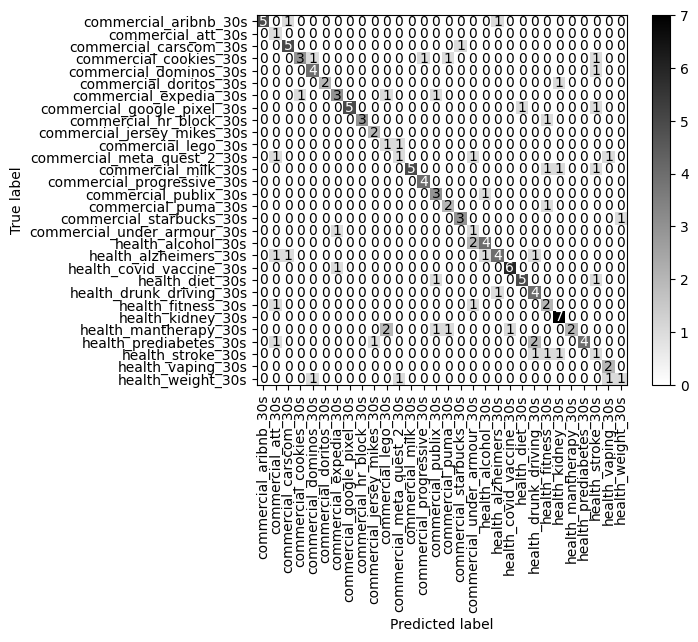

Accuracy Score Dummy: 
0.013513513513513514
[0.04237288 0.02542373 0.05932203 0.05084746 0.05084746]
0.04576271186440678

1
_50nd
Accuracy Score Real: 
0.4527027027027027
[0.45762712 0.41525424 0.33898305 0.38135593 0.41880342]
0.4024047515572938



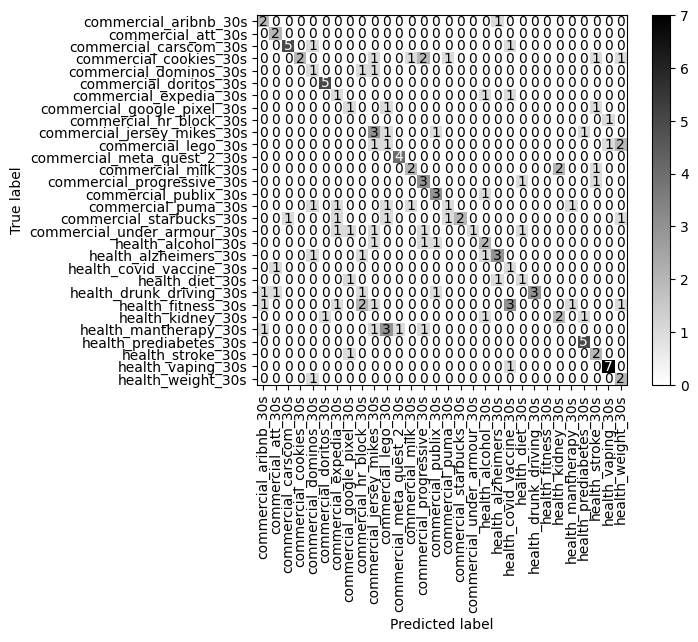

Accuracy Score Dummy: 
0.02027027027027027
[0.05084746 0.05084746 0.01694915 0.02542373 0.02564103]
0.033941764450239026

2
_50wd
Accuracy Score Real: 
0.22972972972972974
[0.29661017 0.3220339  0.21186441 0.27118644 0.29661017]
0.2796610169491525



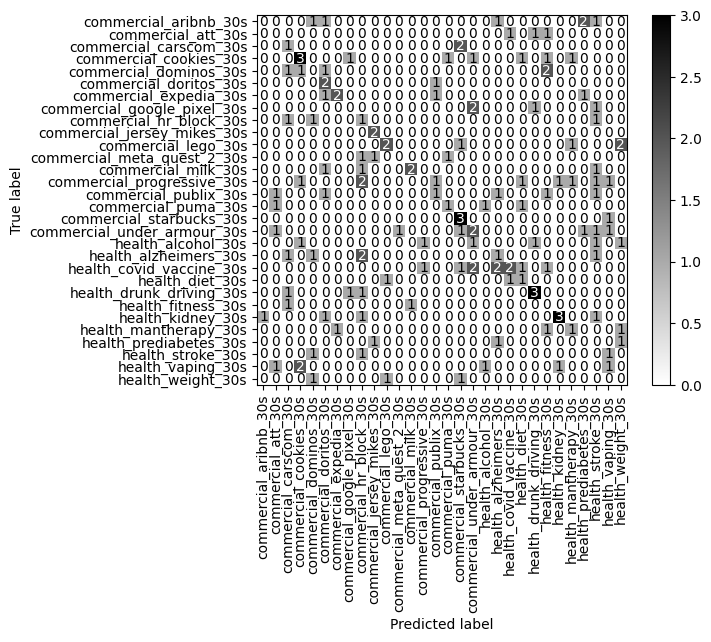

Accuracy Score Dummy: 
0.02702702702702703
[0.03389831 0.00847458 0.05932203 0.00847458 0.03389831]
0.0288135593220339



In [8]:

for select_condition in range(3):  #= 0 #0 = 100, 1 = 50nd, 2 = 50wd
    print(select_condition)
    print(endings[select_condition])

    all_data = [];
    labels = [];

    for curr_file in file_list:
        #for curr_ending in endings:
            curr_ending = endings[select_condition]
            #print(curr_ending)
            file_to_load = data_folder + curr_file + curr_ending + '.npy'
            loaded_data = np.load(file_to_load)
            [n, y] = loaded_data.shape
            all_data.extend(loaded_data)
            labels.extend( [curr_file] * n)
    #labels   

    X = np.asarray(all_data)
    #print(X.shape);
    X = np.nan_to_num(X)

    X = X[:, cut_out:]  ###reduce to number
    #print(X.shape);
    #plt.imshow(X, cmap = 'seismic');
    #plt.colorbar();
    #plt.imshow(X);

    y = np.asarray(labels)
    #y[:25]


    #X, y = load_arrow_head()
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = TimeSeriesForestClassifier()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    print('Accuracy Score Real: ')
    print(accuracy_score(y_test, y_pred))
    
    # Cross validate the pipeline
    cv = KFold(n_splits= n_splits, shuffle=True, random_state=42)
    
    scores = cross_val_score(classifier, X, y, cv= cv)
    cv_results[select_condition, :] = scores
    print(scores)
    print(scores.mean())

    print('')
    cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=classifier.classes_)
    #disp.plot()
    disp.plot(xticks_rotation='vertical',cmap = 'gray_r')

    plt.show()



    dummy_clf = DummyClassifier(strategy="uniform")
    dummy_clf.fit(X_train, y_train)
    y_pred_dummy = dummy_clf.predict(X_test)
    print('Accuracy Score Dummy: ')
    print(accuracy_score(y_test, y_pred_dummy))
    
    # Cross validate the pipeline
    scores = cross_val_score(dummy_clf, X, y, cv= cv)
    print(scores)
    print(scores.mean())
    
    print('')

    cm2 = confusion_matrix(y_test, y_pred_dummy, labels=dummy_clf.classes_)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm2,
    #                              display_labels=dummy_clf.classes_)
    #disp.plot()
    #plt.show()

    #print(np.sum(np.diag(cm, k=0))/len(y_pred))   # len(y_pred) = 148
    #print(np.sum(np.diag(cm2, k=0))/len(y_pred))   # len(y_pred) = 148

,100%,50% nd,50% wd
count,5.000000,5.000000,5.000000
mean,0.559322,0.402405,0.279661
std,0.054922,0.044578,0.041947
min,0.491525,0.338983,0.211864
25%,0.542373,0.381356,0.271186
50%,0.559322,0.415254,0.296610
75%,0.559322,0.418803,0.296610
max,0.644068,0.457627,0.322034


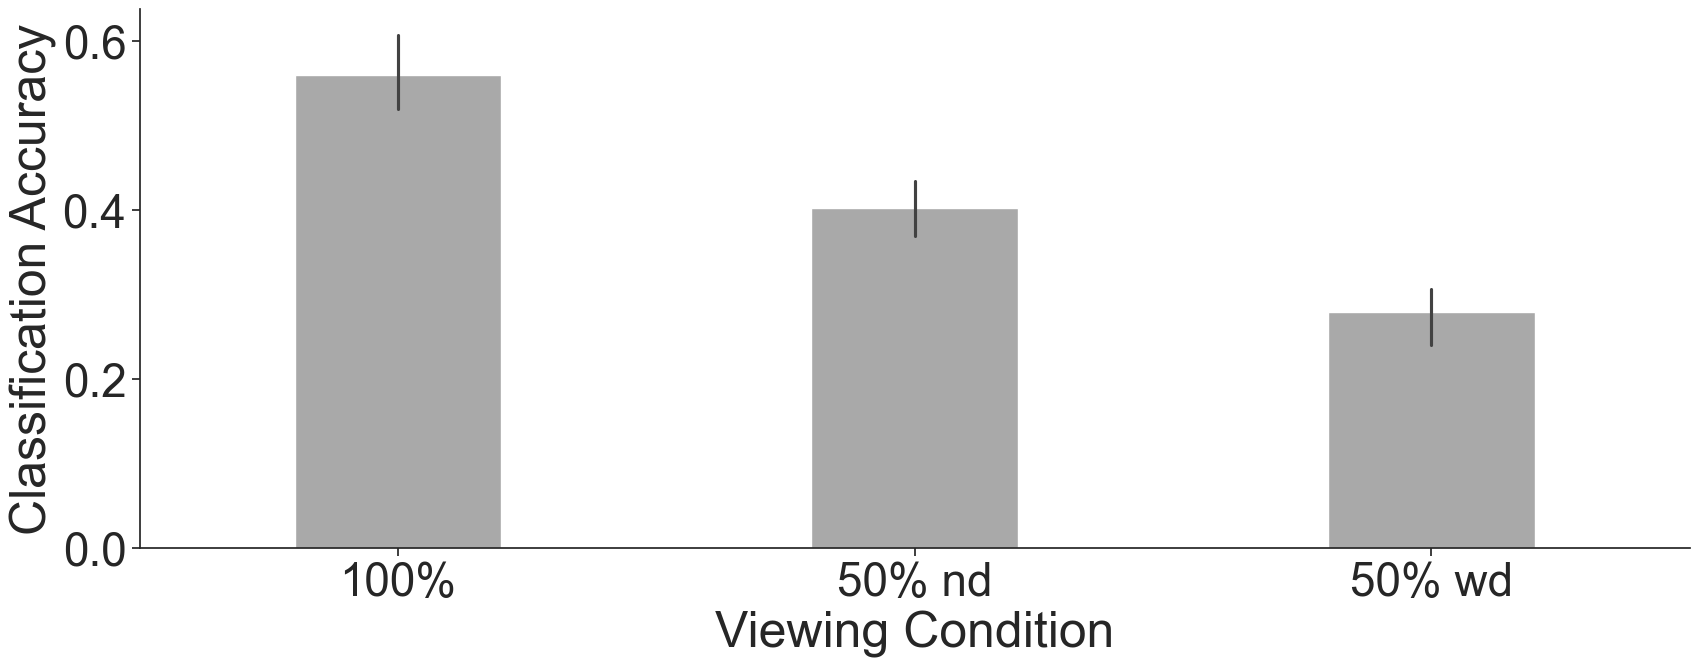

In [9]:
df = pd.DataFrame(cv_results.T, columns = ['100%' , '50% nd', '50% wd'])


sns.set(font_scale=3)
sns.set_style("ticks")

plt.figure(figsize = (20, 7))
sns.barplot(df, color="darkgray", width = 0.4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel('Classification Accuracy')
plt.xlabel('Viewing Condition')

df.describe()